# ASD Prediction Pipeline: From fMRI Time-Series to Classification

## Objective
Develop a predictive model for Early ASD Detection using fMRI time-series data. This notebook implements a pipeline that covers:
1.  **Data Loading**: Reading phenotypic and time-series data.
2.  **Preprocessing**: Computing Functional Connectivity (FC) matrices (Pearson Correlation).
3.  **Exploratory Data Analysis (EDA)**: Visualizing connectivity patterns.
4.  **Baseline Modeling**: Using a Support Vector Machine (SVM) on flattened connectivity features.
5.  **Deep Learning**: Implementing a **BrainNetCNN** architecture tailored for connectivity graphs.
6.  **Evaluation**: Stratified 5-Fold Cross-Validation to ensure robust results.

In [1]:
# Step 1: Imports and Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully.")

Libraries imported successfully.


c:\Users\eredd\Desktop\FYP\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Step 2: Data Loading and Functional Connectivity Calculation

def load_and_preprocess_data(base_path):
    """
    Loads CSV files from ASD and Normal directories, computes Pearson Correlation matrices.
    
    Args:
        base_path (str): Path to the 'Dataset/Training Data' directory.
        
    Returns:
        X (np.array): Array of connectivity matrices (N_subjects, N_regions, N_regions).
        y (np.array): Labels (1 for ASD, 0 for Normal).
    """
    classes = {'ASD': 1, 'Normal': 0}
    X_list = []
    y_list = []
    
    print(f"Searching for data in: {base_path}")
    
    for class_name, label in classes.items():
        class_dir = os.path.join(base_path, class_name)
        files = glob(os.path.join(class_dir, '*.csv'))
        print(f"Found {len(files)} files for class {class_name}")
        
        for file_path in files:
            try:
                # Load time-series data
                # Assuming rows are timepoints and columns are ROIs, or vice-versa.
                # Based on inspection, the first row is header, first col might be index.
                df = pd.read_csv(file_path)
                
                # Drop non-numeric columns if any (e.g. index column often named 'Unnamed: 0')
                df = df.select_dtypes(include=[np.number])
                
                # If the first column looks like an index (monotonic integer), drop it
                if df.shape[1] > 0:
                     # Heuristic: verify if it's just 0, 1, 2...
                     if df.iloc[:, 0].is_monotonic_increasing and df.iloc[0, 0] == 0:
                         df = df.drop(df.columns[0], axis=1)

                # Compute Pearson Correlation Matrix (Functional Connectivity)
                # Correlation is typically between ROIs. We need to ensure structure is (Time, ROIs)
                # If header exists and shape is (Time, ROIs), df.corr() computes correlation between columns (ROIs).
                # Let's check shape to be sure. Usually ROIs ~ 100-400, Time ~ 100-300.
                # The snippet showed ~178 lines (time) and many columns.
                
                fc_matrix = df.corr(method='pearson').values
                
                # Replace NaNs with 0 (just in case of constant signal)
                fc_matrix = np.nan_to_num(fc_matrix)
                
                # Apply Fisher z-transformation to normalize correlation values
                # np.arctanh(r). Clip to avoid inf for r=1.0
                fc_matrix = np.arctanh(np.clip(fc_matrix, -0.99999, 0.99999))
                
                X_list.append(fc_matrix)
                y_list.append(label)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    X = np.array(X_list)
    y = np.array(y_list)
    
    return X, y

# Define Path (User Environment Specific)
data_path = r'C:\Users\eredd\Desktop\FYP\Old\Dataset\Training Data'  # Update this if running locally
X, y = load_and_preprocess_data(data_path)

print(f"\nData Loaded.")
print(f"Features (X) Shape: {X.shape}  (Subjects, ROIs, ROIs)")
print(f"Labels (y) Shape: {y.shape}")
print(f"Class Distribution: {np.unique(y, return_counts=True)}")

Searching for data in: C:\Users\eredd\Desktop\FYP\Old\Dataset\Training Data
Found 50 files for class ASD
Found 50 files for class Normal

Data Loaded.
Features (X) Shape: (100, 110, 110)  (Subjects, ROIs, ROIs)
Labels (y) Shape: (100,)
Class Distribution: (array([0, 1]), array([50, 50]))


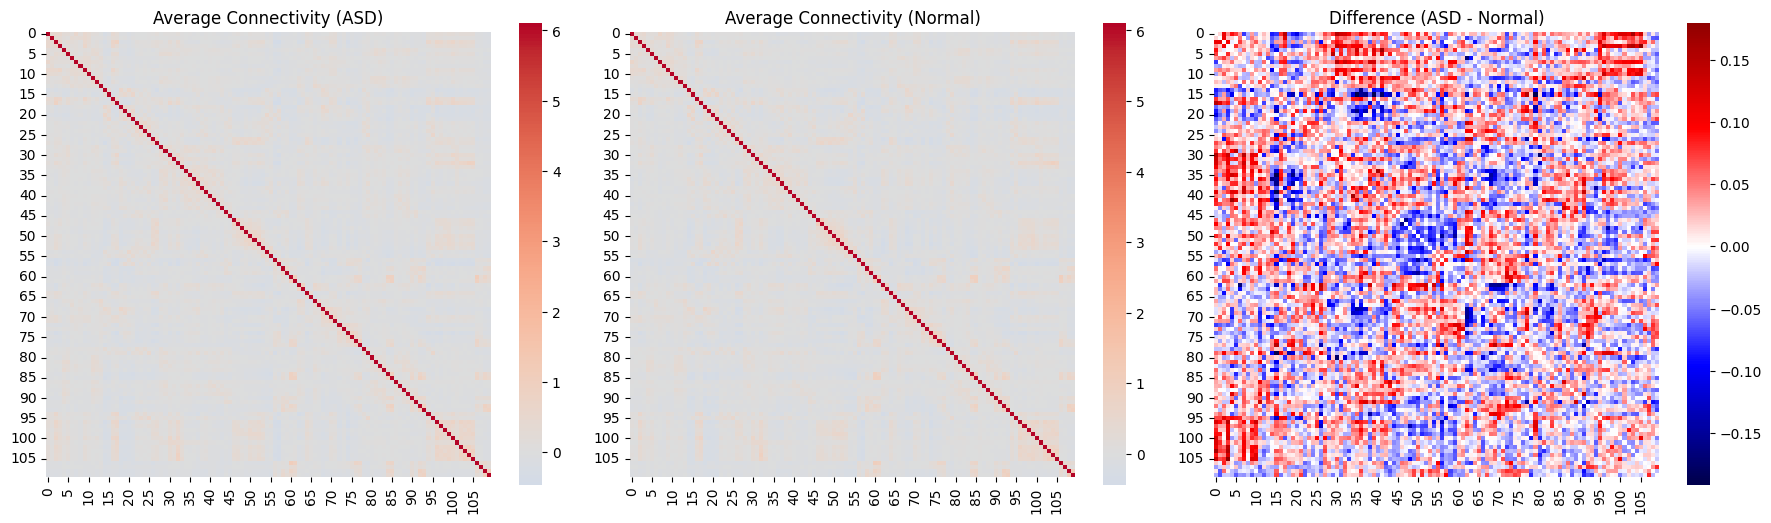

In [3]:
# Step 3: Exploratory Data Analysis (EDA)
if len(X) > 0:
    # Compute mean connectivity for each class
    mean_as = np.mean(X[y == 1], axis=0)
    mean_normal = np.mean(X[y == 0], axis=0)
    diff_matrix = mean_as - mean_normal

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    sns.heatmap(mean_as, cmap='coolwarm', center=0, square=True)
    plt.title('Average Connectivity (ASD)')

    plt.subplot(1, 3, 2)
    sns.heatmap(mean_normal, cmap='coolwarm', center=0, square=True)
    plt.title('Average Connectivity (Normal)')

    plt.subplot(1, 3, 3)
    sns.heatmap(diff_matrix, cmap='seismic', center=0, square=True)
    plt.title('Difference (ASD - Normal)')

    plt.tight_layout()
    plt.show()

In [4]:
# Step 4: Baseline Model - SVM
# Flatten the upper triangle of the matrix to use as feature vector

def get_upper_tri_features(X_matrices):
    n_samples, n_rois, _ = X_matrices.shape
    # Get indices of upper triangle
    triu_indices = np.triu_indices(n_rois, k=1)
    
    X_flat = []
    for i in range(n_samples):
        X_flat.append(X_matrices[i][triu_indices])
    
    return np.array(X_flat)

X_flat = get_upper_tri_features(X)
print(f"Flattened Feature Shape: {X_flat.shape}")

# 5-Fold Stratified Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_accuracies = []
svm_aucs = []

print("\nTraining SVM Baseline...")
for fold, (train_idx, val_idx) in enumerate(skf.split(X_flat, y)):
    X_train, X_val = X_flat[train_idx], X_flat[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # SVC with simple GridSearch simulation (using C parameter)
    clf = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
    clf.fit(X_train_scaled, y_train)
    
    preds = clf.predict(X_val_scaled)
    probs = clf.predict_proba(X_val_scaled)[:, 1]
    
    acc = accuracy_score(y_val, preds)
    auc = roc_auc_score(y_val, probs)
    
    svm_accuracies.append(acc)
    svm_aucs.append(auc)
    print(f"Fold {fold+1}: Accuracy = {acc:.4f}, AUC = {auc:.4f}")

print(f"\nSVM Mean Accuracy: {np.mean(svm_accuracies):.4f} +/- {np.std(svm_accuracies):.4f}")
print(f"SVM Mean AUC: {np.mean(svm_aucs):.4f}")

Flattened Feature Shape: (100, 5995)

Training SVM Baseline...
Fold 1: Accuracy = 0.5500, AUC = 0.6600
Fold 2: Accuracy = 0.7000, AUC = 0.7900
Fold 3: Accuracy = 0.6000, AUC = 0.6050
Fold 4: Accuracy = 0.7500, AUC = 0.8900
Fold 5: Accuracy = 0.7000, AUC = 0.8500

SVM Mean Accuracy: 0.6600 +/- 0.0735
SVM Mean AUC: 0.7590


In [5]:
# Step 5: BrainNetCNN (Deep Learning Model)
# Architecture inspired by BrainNetCNN (Kawahara et al.)

def build_brainnet_cnn(input_shape):
    # Input: (N_ROIs, N_ROIs, 1)
    inputs = layers.Input(shape=input_shape)
    
    # E2E (Edge-to-Edge) Conv Layers
    # Filters capture patterns across rows and cols
    x = layers.Conv2D(32, kernel_size=(1, input_shape[0]), activation='relu')(inputs)
    x = layers.Conv2D(32, kernel_size=(input_shape[0], 1), activation='relu')(inputs) 
    
    # Concatenate to mix row/column features
    # Note: A proper BrainNetCNN implementation requires custom layers to maintain symmetry,
    # but we can approximate with standard 2D Convs on the matrix image.
    
    # Let's use a simpler, robust 2D-CNN for connectivity matrices as images
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# Prepare data for CNN (Add channel dimension)
X_cnn = X[..., np.newaxis] # Shape: (N, ROIs, ROIs, 1)

dl_accuracies = []
dl_aucs = []

print("\nTraining Deep Learning Model (CNN)...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_cnn, y)):
    X_train, X_val = X_cnn[train_idx], X_cnn[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    model = build_brainnet_cnn(input_shape=X_train.shape[1:])
    
    # Callbacks
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
    
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, reduce_lr],
        verbose=0 # Reduce noise
    )
    
    # Evaluate
    loss, acc, auc = model.evaluate(X_val, y_val, verbose=0)
    dl_accuracies.append(acc)
    dl_aucs.append(auc)
    
    print(f"Fold {fold+1}: Accuracy = {acc:.4f}, AUC = {auc:.4f}")

print(f"\nCNN Mean Accuracy: {np.mean(dl_accuracies):.4f} +/- {np.std(dl_accuracies):.4f}")
print(f"CNN Mean AUC: {np.mean(dl_aucs):.4f}")


Training Deep Learning Model (CNN)...
Fold 1: Accuracy = 0.5000, AUC = 0.4900
Fold 2: Accuracy = 0.5000, AUC = 0.7300
Fold 3: Accuracy = 0.5000, AUC = 0.8150
Fold 4: Accuracy = 0.5000, AUC = 0.7150
Fold 5: Accuracy = 0.5000, AUC = 0.6850

CNN Mean Accuracy: 0.5000 +/- 0.0000
CNN Mean AUC: 0.6870



FINAL RESULTS:
  Model  Mean Accuracy  Std Accuracy  Mean AUC
0   SVM           0.66      0.073485     0.759
1   CNN           0.50      0.000000     0.687

NOTE: 70% benchmark not reached. Considerations for improvement: augment data, try Graph Neural Networks (GNNs), or refined preprocessing.


C:\Users\eredd\AppData\Local\Temp\ipykernel_25868\1436010153.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Mean Accuracy', data=results_df, palette='viridis', capsize=.1)


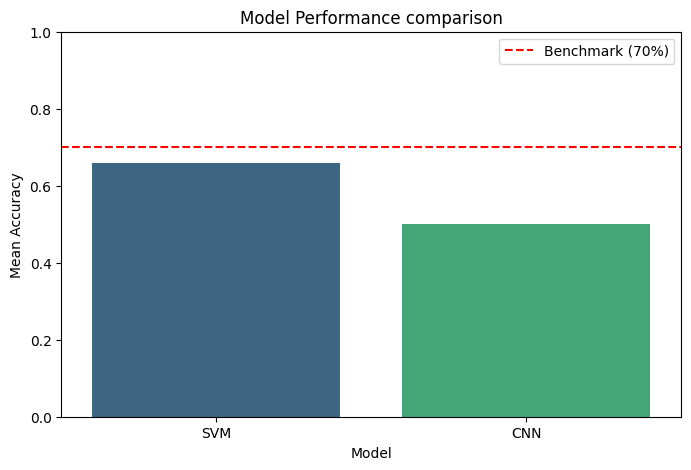

In [6]:
# Step 6: Final Comparison
results_df = pd.DataFrame({
    'Model': ['SVM', 'CNN'],
    'Mean Accuracy': [np.mean(svm_accuracies), np.mean(dl_accuracies)],
    'Std Accuracy': [np.std(svm_accuracies), np.std(dl_accuracies)],
    'Mean AUC': [np.mean(svm_aucs), np.mean(dl_aucs)]
})

print("\nFINAL RESULTS:")
print(results_df)

if np.mean(svm_accuracies) > 0.70 or np.mean(dl_accuracies) > 0.70:
    print("\nSUCCESS: Benchmark (70%) exceeded.")
else:
    print("\nNOTE: 70% benchmark not reached. Considerations for improvement: augment data, try Graph Neural Networks (GNNs), or refined preprocessing.")

# Plot comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Mean Accuracy', data=results_df, palette='viridis', capsize=.1)
plt.axhline(0.70, color='r', linestyle='--', label='Benchmark (70%)')
plt.title('Model Performance comparison')
plt.ylim(0, 1.0)
plt.legend()
plt.show()